In [169]:
import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)

from numpy.linalg import eigh as eigh

from SparseStochMat import sparse_autocov_mat

import auxiliary_functions
import networkx as nx

In [255]:
time = [i for i in np.linspace(0,5,100)]
N = 50

In [256]:
p= 5/N
c= 5
er_adj = nx.adjacency_matrix(nx.erdos_renyi_graph(N, p))

In [257]:
er_rw = StaticTempNetwork(times = time, adjacency = csr_matrix(er_adj))
er_rw.compute_laplacian_matrices(random_walk = True)

er_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
er_rw.compute_transition_matrices(lamda=1)


er_heat = StaticTempNetwork(times = time, adjacency = csr_matrix(er_adj))
er_heat.compute_laplacian_matrices(random_walk = False)

er_heat.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
er_heat.compute_transition_matrices(lamda=1)

## Forward Diffusion

In [258]:
p0 = np.random.uniform(low=0, high=1, size=N)
p0 /= np.sum(p0)
p = [p0]
p += [p0 @ T for T in er_heat.T[1]]

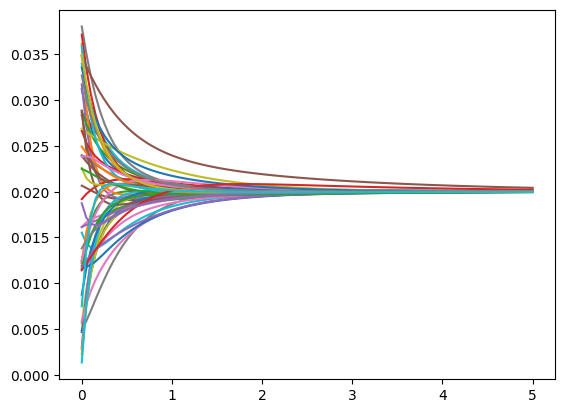

In [259]:
plt.plot(time, p)
plt.show()

## Backward Diffusion

In [260]:
er_heat.laplacians.toarray()

array([[ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  8.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  7., ..., -1.,  0.,  0.],
       ...,
       [ 0.,  0., -1., ...,  4.,  0., -1.],
       [ 0., -1.,  0., ...,  0.,  3.,  0.],
       [ 0.,  0.,  0., ..., -1.,  0.,  8.]])

In [261]:
def inverse_diffusion(L, t):
    eigs, V = eigh(L)
    eigs_exp = np.exp(-t * eigs)
    D_exp = np.diag(eigs_exp)
    T_inv = V @ D_exp @ np.transpose(V)
    return T_inv

In [262]:
inverse_diffusion(er_heat.laplacians.toarray(), 1)

array([[0.04761963, 0.02107683, 0.01547576, ..., 0.0221161 , 0.03046822,
        0.01884149],
       [0.02107683, 0.03153659, 0.01986269, ..., 0.01780669, 0.03500789,
        0.02004859],
       [0.01547576, 0.01986269, 0.03932274, ..., 0.03551205, 0.01292083,
        0.03272903],
       ...,
       [0.0221161 , 0.01780669, 0.03551205, ..., 0.05982439, 0.01573705,
        0.03305389],
       [0.03046822, 0.03500789, 0.01292083, ..., 0.01573705, 0.11469827,
        0.01419047],
       [0.01884149, 0.02004859, 0.03272903, ..., 0.03305389, 0.01419047,
        0.03243385]])

In [263]:
p0.sum()

1.0

In [264]:
p0 = np.random.uniform(low=0, high=1, size=N)
p0 /= np.sum(p0)
p = [p0]
p = [p0 @ inverse_diffusion(er_heat.laplacians.toarray(), t) for t in time]

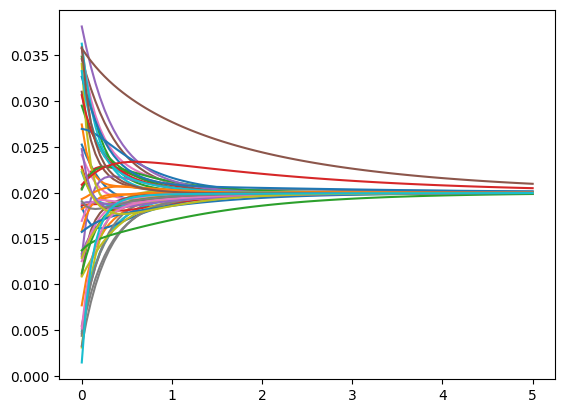

In [265]:
plt.plot(time, p)
plt.show()

In [266]:
list_T = [T.toarray() for T in er_heat.T[1]]
list_T = [np.identity(N)] + list_T

In [276]:
list_T[-1] @ inverse_diffusion(er_heat.laplacians.toarray(), time[1]) 

array([[0.0200784 , 0.02008824, 0.02008201, ..., 0.02008003, 0.02009866,
        0.02008067],
       [0.02008824, 0.02015546, 0.02015453, ..., 0.02012932, 0.02010207,
        0.02014619],
       [0.02008201, 0.02015453, 0.02021562, ..., 0.02018157, 0.02005154,
        0.02018776],
       ...,
       [0.02008003, 0.02012932, 0.02018157, ..., 0.0201613 , 0.02006342,
        0.02015969],
       [0.02009866, 0.02010207, 0.02005154, ..., 0.02006342, 0.02021863,
        0.02006239],
       [0.02008067, 0.02014619, 0.02018776, ..., 0.02015969, 0.02006239,
        0.02016778]])

In [267]:
[list_T[i] @ inverse_diffusion(er_heat.laplacians.toarray(), t) for i, t in enumerate(time)]

[array([[ 1.00000000e+00,  3.75419120e-16, -6.14527939e-17, ...,
          5.90368324e-17,  6.34100203e-17,  1.79331445e-16],
        [ 3.75419120e-16,  1.00000000e+00, -4.52388536e-16, ...,
          1.02078207e-16,  8.20756736e-17, -6.96390392e-16],
        [-6.14527939e-17, -4.52388536e-16,  1.00000000e+00, ...,
          7.32180924e-16, -2.29679320e-16,  1.41176787e-16],
        ...,
        [ 5.90368324e-17,  1.02078207e-16,  7.32180924e-16, ...,
          1.00000000e+00, -3.79050110e-17,  2.80594077e-16],
        [ 6.34100203e-17,  8.20756736e-17, -2.29679320e-16, ...,
         -3.79050110e-17,  1.00000000e+00,  2.86388113e-16],
        [ 1.79331445e-16, -6.96390392e-16,  1.41176787e-16, ...,
          2.80594077e-16,  2.86388113e-16,  1.00000000e+00]]),
 array([[6.18804447e-01, 3.23566278e-03, 3.15101731e-04, ...,
         3.24936921e-03, 3.65538896e-03, 3.05209909e-03],
        [3.23566278e-03, 4.66208287e-01, 2.83186741e-03, ...,
         5.00495275e-04, 5.95638021e-02, 3.2075